In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRFRegressor
% matplotlib inline
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import gc
import warnings
import time

from scipy.stats import binom

from lightgbm import LGBMClassifier, LGBMRanker

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def dropUninformativeFeatures(data):
    """Drop features with one unique value"""
    cols_to_drop = []
    
    for col in data.columns:
        if len(data[col].unique()) == 1:
            cols_to_drop.append(col)
   
    if len(cols_to_drop) > 0:
        data.drop(columns=cols_to_drop, inplace=True)

def getNumCatFeats(data):
    import re
    num_f = [idx for idx, col in enumerate(data.columns) if int(re.search('\d+', col).group()) <= 190]
    cat_f = [idx for idx, col in enumerate(data.columns) if int(re.search('\d+', col).group()) > 190]
    names_num_f = [col for col in data.columns if int(re.search('\d+', col).group()) <= 190]
    names_cat_f = [col for col in data.columns if int(re.search('\d+', col).group()) > 190]
    return num_f, cat_f, names_num_f, names_cat_f

def LabelEnc(data, cat_features):
    data1 = data.copy()
    data1 = data1.fillna(0)
    enc = LabelEncoder()
    for feat in cat_features:
        data1.loc[:, feat] = enc.fit_transform(data.loc[:, feat].astype(str))
    return data1


        
#кросс-валидация
def KFold(estimator, data, target, weights, n_folds = 5):
    scf = StratifiedKFold(n_splits = n_folds)
    y_scores = pd.DataFrame()
    y_tests = pd.DataFrame()
    fold = 1
    for train_index, test_index in scf.split(data, target):
        estimator.fit(data.iloc[train_index, :], target.iloc[train_index], sample_weight = weights)
        y_scores['Fold_' + str(fold)] = pd.Series(estimator.predict_proba(data.iloc[test_index, :])[:,1])
        y_tests['Fold_' + str(fold)] = pd.Series(target.iloc[test_index].values.flatten())
        fold = fold + 1
    return y_scores, y_tests

def ROCCurve(y_true, y_probas):
    plt.figure(figsize=(10,10))
    linewidth = 2
    n = 1
    mean_roc = []
    # для каждого фолда
    for i,j in zip(y_true, y_probas):
        fpr, tpr, thresholds = roc_curve(y_true[i].dropna(),y_probas[j].dropna())
        roc = round(auc(fpr,tpr),2)
        mean_roc.append(roc)
        plt.plot(fpr, tpr, color='g', label='ROC Fold '+str(n)+ f' Area = {roc}', lw=linewidth)
        n += 1
    plt.plot([0, 1], [0, 1], color='b', lw=linewidth, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.1])
    plt.ylim([0.0, 1.1])
    plt.legend(loc="lower right")
    mean_roc = np.array(mean_roc)
    plt.title(f'ROC curve: Mean ROC={round(mean_roc.mean(), 2)}')
    plt.show()
    
#undersampling
def undersampling(data, target, balance):
    """balance - share of class 1, balance >= 1"""
    data1 = pd.concat([data, target], axis=1, ignore_index=True)
    dataChurn = data1[target.values == 1]
    dataNoChurn = data1[target.values == -1]
    countFirst = len(dataChurn) * balance if len(dataChurn) * balance<= len(dataNoChurn) else len(dataNoChurn)
    dataChurn = dataChurn.append(dataNoChurn.iloc[:countFirst,:], ignore_index=True)
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:-1], dataChurn.iloc[:,-1]

def importOfFeats(data, estimator):
    """Return importance of features calculated by the estimator"""
    df = pd.DataFrame(data=estimator.feature_importances_, columns=['feature_importances'])
    df['feature'] = data.columns.values
    df.sort_values("feature_importances", inplace=True, ascending=False)

    
    fig = plt.figure(figsize=(25, 65))
    ax = fig.add_subplot(111)
    
    plt.barh(np.arange(df.shape[0]), df.feature_importances.values, color='g')
    plt.yticks(np.arange(df.shape[0]), df["feature"])
    plt.show()
    
    return df

In [27]:
#загрузка данных
train = pd.read_csv('train_data.csv')
labels = pd.read_csv('train_labels.csv')

print(train.shape, labels.shape)

hold_out_data = pd.read_csv('hold_out_data.csv')
hold_out_labels = pd.read_csv('hold_out_labels.csv')

print(hold_out_data.shape, hold_out_labels.shape)

(30000, 230) (30000, 1)
(10000, 230) (10000, 1)


# Обработка данных

In [28]:
# заполнение пропусков нулями
train = train.fillna(0)
hold_out_data = hold_out_data.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train)
hold_out_data = hold_out_data.loc[:, train.columns.values]

# определение категориальных, численных признаков
num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train)

#кодирование категориальных признаков
united_data = train.append(hold_out_data, ignore_index=True)

enc_data = LabelEnc(united_data, names_cat_f)

train = enc_data.iloc[:train.shape[0], :]
hold_out_data = enc_data.iloc[train.shape[0]:, :]

# самые информативные 50 признаков
best_feats = ['Var126', 'Var217', 'Var189', 'Var113', 'Var81', 'Var73', 'Var74', 'Var28',
 'Var192', 'Var199', 'Var57', 'Var198', 'Var210', 'Var6', 'Var218', 'Var212',
 'Var222', 'Var134', 'Var13', 'Var140', 'Var202', 'Var205', 'Var94', 'Var220',
 'Var197', 'Var149', 'Var125', 'Var204', 'Var153', 'Var229', 'Var226', 'Var214',
 'Var76', 'Var216', 'Var133', 'Var38', 'Var21', 'Var195', 'Var112', 'Var200',
 'Var24', 'Var83', 'Var53', 'Var207', 'Var123', 'Var66', 'Var211', 'Var163',
 'Var35', 'Var85']

hold_out_data = hold_out_data[best_feats]
train = train[best_feats]

# Обучение модели

In [29]:
estimator = XGBClassifier(colsample_bytree = 1.0, max_depth = 4,\
                          min_child_weight = 1, n_estimators = 90,\
                          reg_alpha = 0.2, reg_lambda = 0.9, subsample = 0.8)

estimator.fit(train, labels, eval_metric='auc', early_stopping_rounds=20, eval_set=[(hold_out_data, hold_out_labels)])

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.675736
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.673853
[2]	validation_0-auc:0.692149
[3]	validation_0-auc:0.696425
[4]	validation_0-auc:0.696849
[5]	validation_0-auc:0.697886
[6]	validation_0-auc:0.705446
[7]	validation_0-auc:0.706817
[8]	validation_0-auc:0.706752
[9]	validation_0-auc:0.712008
[10]	validation_0-auc:0.71211
[11]	validation_0-auc:0.713085
[12]	validation_0-auc:0.713462
[13]	validation_0-auc:0.712957
[14]	validation_0-auc:0.713801
[15]	validation_0-auc:0.714287
[16]	validation_0-auc:0.7143
[17]	validation_0-auc:0.71719
[18]	validation_0-auc:0.718311
[19]	validation_0-auc:0.719354
[20]	validation_0-auc:0.720168
[21]	validation_0-auc:0.721679
[22]	validation_0-auc:0.722047
[23]	validation_0-auc:0.722095
[24]	validation_0-auc:0.723056
[25]	validation_0-auc:0.72161
[26]	validation_0-auc:0.72317
[27]	validation_0-auc:0.724396
[28]	validation_0-auc:0.724435
[29]	validation_0-auc:0.725575
[30]	validation_0-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=90, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.2, reg_lambda=0.9, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

# Предсказание результатов

In [30]:
results = pd.DataFrame(data=hold_out_labels.values, columns=['true_labels'])
results['predicted_proba'] = estimator.predict_proba(hold_out_data)[:, 1]

In [31]:
print('roc_auc_score', roc_auc_score(hold_out_labels.values, results.predicted_proba))

roc_auc_score 0.7363343509818682


In [32]:
pred = estimator.predict(hold_out_data)
print('precision_score', precision_score(hold_out_labels.values, pred))
print('recall_score', recall_score(hold_out_labels.values, pred))
print('recall_score', f1_score(hold_out_labels.values, pred))

precision_score 0.7142857142857143
recall_score 0.013440860215053764
recall_score 0.026385224274406333


# Оценка потенциального экономического эффекта от внедрения полученного решения

Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике.

Например, введите следующие параметры:

* сколько денег в среднем приносит один пользователь в месяц;

* сколько денег в среднем вы будете вкладывать в удержание одного пользователя;

* с какой вероятностью пользователь примет ваше предложение;

* сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.

В связи с недоступностью информации о доходе компании с одного человека и других параметрах, будут использоваться искусственные значения показателей.

Параметры:

* в среднем приносит один пользователь в месяц 400р.

* сколько денег в среднем вы будете вкладывать в удержание одного пользователя:
    * 15% скидка пользователям, склонным к оттоку на срок 12 месяцев;
    * затраты на работу сотрудников (телефонный разговор): среднее время разговора 8 минут, зарплата сотрудника 30т.руб. зарплата сотрудника/ 22 рабочих дня/  8 часов/ (8/60) = 22.7 рубля


* с вероятностью 70% пользователь примет предложение;

* топ ранжированию по модели будет участвовать в кампании по удержанию.

## Рассчитаем экономический эффект от проведения кампании (= сколько денег мы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование модели.

Отранжируем пользователей для участия в кампании по удержанию.

In [33]:
users = results.sort_values('predicted_proba', ascending=False)

In [34]:
users.head()

,true_labels,predicted_proba
3377,1,0.669726
5066,-1,0.640180
4148,1,0.628487
7889,1,0.627331
6527,1,0.623044


In [35]:
# функция подсчёта экономического эффекта
def economic_effect(data, top = 0, arpu = 300, discount_amount = 0.2, cost_of_retaining = 26.5, prob_acceptance = 0.6):
    if (top < 0) | (top > 1) | (discount_amount < 0) | (discount_amount > 1) | (prob_acceptance < 0) | (prob_acceptance > 1):
        raise ValueError
    # Доход компании без учёта проведения кампании по удержанию, то есть произойдёт отток клиентов.
    total = sum(data['true_labels'] == -1) * arpu
    # Потери компании на ошибочных удержаниях клиентов. Предполагается, что
    # пользователи не желающие уходить от компании всегда принимают предложение.
    loss_on_erroneous_retention = 0.0
    # Доход компании от удержанных клиентов, желавших уйти, после проведения кампании по удержанию.
    revenue_from_retained_customers = 0.0
    
    if top != 0:
        top_size = int(data.shape[0] * top)
        data_top = data['true_labels'][:top_size]
        
        churn = sum(data_top == 1)
        nochurn = sum(data_top == -1)
        
        loss_on_erroneous_retention = nochurn * arpu * discount_amount + nochurn * cost_of_retaining
        revenue_from_retained_customers = arpu * (1 - discount_amount) * data_top[data_top == 1].astype(int)
        revenue_from_retained_customers = revenue_from_retained_customers.values * \
                                            binom.rvs(1, prob_acceptance, size = churn)
        revenue_from_retained_customers = revenue_from_retained_customers.sum() + churn * cost_of_retaining
    
    # Доход компании после проведения кампании по удержанию клиентов по топу ранжирования по модели
    total = total - loss_on_erroneous_retention + revenue_from_retained_customers

    return total

In [36]:
# визуализация прибыли при удержании топа клиентов
def plot_revenue(data, arpu = 300, discount_amount = 0.15, cost_of_retaining = 22.7, prob_acceptance = 0.65):
    grid_top = np.linspace(0, 1, 500)
    grid_economic_effect = []
    for top in grid_top:
        grid_economic_effect.append(economic_effect(users, top=top, prob_acceptance=prob_acceptance, 
                                                    discount_amount=discount_amount, arpu=arpu, cost_of_retaining = cost_of_retaining))

    plt.figure(figsize=(15,10))
    plt.plot(grid_top*100, grid_economic_effect, color = 'g', label = 'Прибыль с учётом проведения кампании по удержанию клиентов')
    plt.plot(grid_top[0]*100, grid_economic_effect[0], 'bo', label = 'Прибыль без проведения кампании по удержанию клиентов')
    plt.plot(grid_top[-1]*100, grid_economic_effect[-1], 'ro', label = 'Прибыль при удержании всех клиентов')
    plt.legend(loc = 'best')
    plt.grid(True, which='both')
    return grid_economic_effect, grid_top

##  Проанализируем, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию.

Визуализация прибыли компании при удержании пользователей из топа (в %) ранжирования по модели.

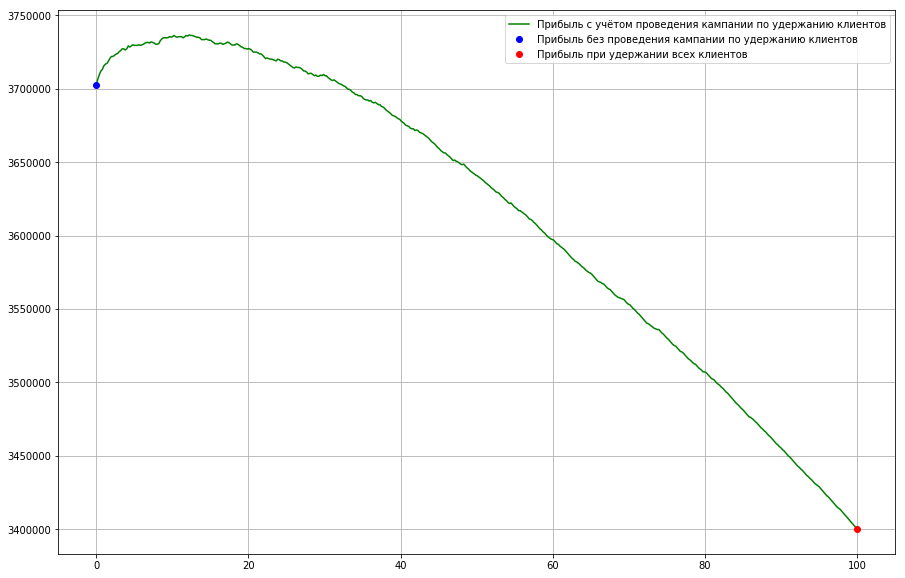

In [37]:
grid_economic_effect, grid_top = plot_revenue(users, cost_of_retaining=0, discount_amount=0.15, arpu=400, prob_acceptance=1)

In [38]:
grid_top[np.argsort(grid_economic_effect)[::-1]][:10]*100

array([12.2244489 , 12.4248497 , 10.22044088, 11.82364729, 12.6252505 ,
       12.0240481 , 12.8256513 ,  9.61923848, 13.0260521 , 10.02004008])

Топ 10-12% пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию, чтобы экономический эффект был наибольшим.

## Изменим стоимость удержания и вероятность, с которой пользователь принимает предложение.

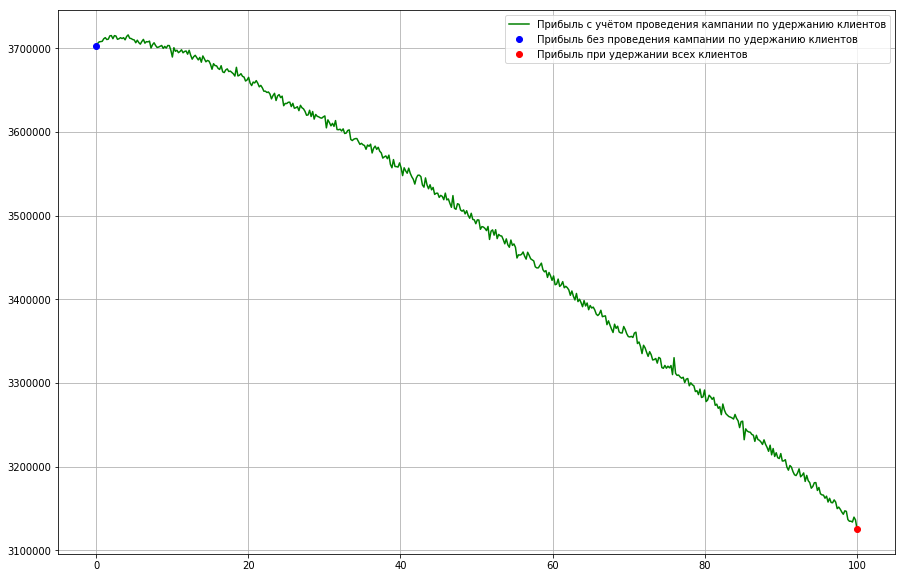

In [39]:
grid_economic_effect, grid_top = plot_revenue(users, cost_of_retaining=22.7, discount_amount=0.15, arpu=400, prob_acceptance=0.7)

In [40]:
grid_top[np.argsort(grid_economic_effect)[::-1]][:10]*100

array([4.20841683, 2.00400802, 2.40480962, 1.80360721, 2.60521042,
       4.00801603, 1.20240481, 3.60721443, 3.20641283, 4.40881764])

In [41]:
np.max(grid_economic_effect)

3715708.0

При снижении вероятности принятия пользователем предложения до 0.7 и увеличении расходов, направленных на удержание пользователя до 22.7 оптимальный размер топа сокращается до 4-5 процентов.

## Применение модели перестаёт быть оправданным при затратах на работу сотрудника по удержанию клиента в 50 и размере предоставляемой скидки в 25% при той же вероятности принятия предложения клиентом.

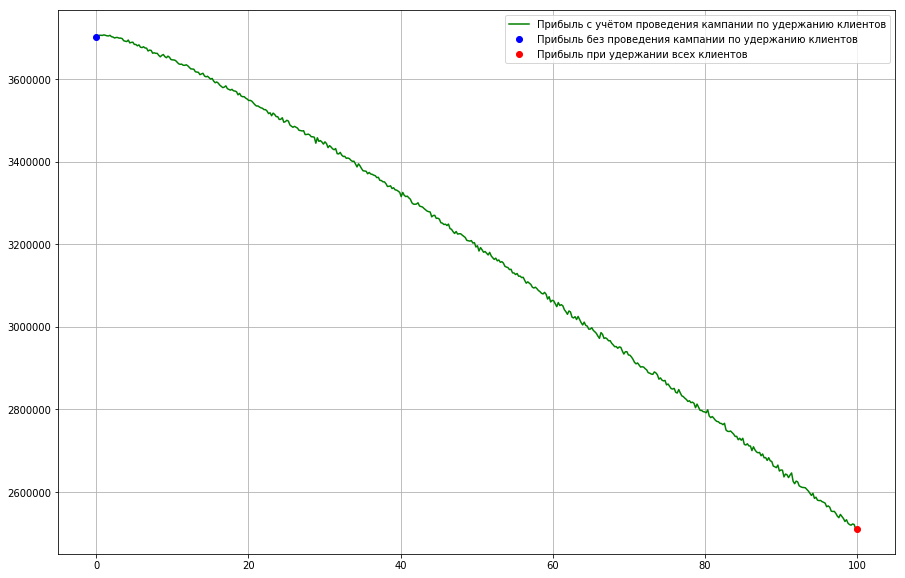

In [18]:
grid_economic_effect, grid_top = plot_revenue(users, cost_of_retaining=50, discount_amount=0.25, arpu=400, prob_acceptance=0.7)

## Увеличение качества модели на 1-3% может не повлиять на экономический эффект, поскольку качество оценивается по метрике roc-auc. Значение roc-auc имеет смысл вероятности того, что если были выбраны случайный положительный и случайный отрицательный объекты выборки, положительный объект получит оценку принадлежности выше, чем отрицательный объект. roc-auc характеризует качество оценок принадлежности к первому классу. То есть, при увеличении качества увеличится уверенность алгоритма, при этом изменения экономического эффекта может и не быть.

* Для увеличения экономического эффекта нужно уменьшать количество ошибок первого и второго рода. Это видно на визуализации ошибочно классифицированных объектов на прошлой неделе, а также по precision_score и recall_score на hold_out подвыборке.

## Вложение средств в улучшение качества модели может быть оправданным в том случае, если это повлечёт снижение количества ошибок первого и второго рода. Чтобы оценить на сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания, нужно оценить затраты на увеличение качества модели, а также предполагаемое(желаемое) изменение экономического эффекта  от увеличения качества модели.
